# Bin Packing

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=0)

## Problem Statement

Given $n$ rational numbers $0 < s_{1}, \dots, s_{n} < 1$, the **bin packing problem** asks for the minimum integer $k \ge 1$ such that there exists a function $f : [n] \to [k]$ for which
$$
\max
    \Bigg\{
        \sum_{i \in f^{-1}(\{j\})} 
            s_{i} 
        \,
        \Bigg\vert
        \,
        j \in [k]
    \Bigg\} 
    < 
    1.
$$

## Complexity

It can be shown that the bin-packing problem is NP-hard. For practical purposes, this means we should look for approximation algorithms rather than exact algorithms.

However, the variant in which the number of different item sizes is a fixed $d = O(1)$, known as "high-multiplicity bin packing", can be solved in polynomial time.

## Algorithms

### Approximation algorithms

In [9]:
num_boxes = 100
box_widths = rng.uniform(0, 1, num_boxes)

In [10]:
def is_valid_packing(box_widths, bins):
  """Checks if `bins` is a valid packing of `box_widths`."""
  if np.any(box_widths > 1) or np.any(box_widths < 0):
    raise ValueError('All entries of `box_widths` must lie between 0 and 1, inclusive.')
  
  x = np.zeros(bins[0].shape)
  for b in bins:
    # If the capacity of the current bin is exceeded, return false.
    if np.sum(box_widths[b == 1]) > 1:
      return False
    
    x += b
    
  # If any box is not in exactly one of the bins, return false.
  if np.any(x != 1):
    return False
  
  # If each box is in exactly one bin, and no bin is overfull, return true.
  return True

# Valid packing since it respects all criteria.
assert is_valid_packing(
  np.array([0.3, 0.6, 0.9]), 
  (np.array([1, 1, 0]), np.array([0, 0, 1]))
)

# Invalid packing since item 1 is placed in more than one bin.
assert not is_valid_packing(
  np.array([0.3, 0.6, 0.9]), 
  (np.array([1, 1, 0]), np.array([0, 1, 1]))
)

# Invalid packing since item 1 is not placed in any bin.
assert not is_valid_packing(
  np.array([0.3, 0.6, 0.9]), 
  (np.array([1, 0, 0]), np.array([0, 0, 1]))
)

# Invalid packing since bin 1 contains item 1 twice.
assert not is_valid_packing(
  np.array([0.3, 0.6, 0.9]), 
  (np.array([1, 0, 0]), np.array([0, 2, 1]))
)

# Invalid packing since the capacity of bin 1 is exceeded.
assert not is_valid_packing(
  np.array([0.3, 0.6, 0.9]), 
  (np.array([1, 0, 0]), np.array([0, 1, 1]))
)

#### NEXT-FIT

A simple approximation algorithms for the bin-packing problem is the **NEXT-FIT** algorithm. It keeps only one bin open and places the current item in the bin if it fits, or opens a new bin if it does not.

In [11]:
def next_fit(box_widths):
  """Solves BIN-PACKING approximately using NEXT-FIT."""
  
  num_boxes = box_widths.size
  
  bins = []
  current_bin = np.zeros(num_boxes)
  available_space = 1
  for i in range(num_boxes):
    box_width = box_widths[i]
    
    # If the current box is too wide, open a new bin.
    if box_width > available_space:
      bins.append(current_bin)
      current_bin = np.zeros(num_boxes)
      available_space = 1
    
    # Place the current box in current bin.
    current_bin[i] = 1
    available_space -= box_width
  
  bins.append(current_bin) # Append the final bin.
  
  return tuple(bins)

bins = next_fit(box_widths)
assert is_valid_packing(box_widths, bins)

print(f'Number of bins used by NEXT-FIT: {len(bins)}.')

Number of bins used by NEXT-FIT: 70.


#### FIRST-FIT

A slightly more sophisticated algorithm is the **FIRST-FIT** algorithm. This algorithm keeps all bins open and placed each item in the first bin with enough remaining space to fit the item.

In [12]:
def first_fit(box_widths):
  """Solves BIN-PACKING approximately using FIRST-FIT."""
  
  num_boxes = box_widths.size
  
  # Start with one empty bin.
  bins = [np.zeros(num_boxes)]
  available_space = [1]
  
  for i in range(box_widths.size):
    box_width = box_widths[i]
    is_box_placed = False
    j = 0
    while not is_box_placed and j < len(bins):
      # Place box i in bin j if it fits.
      if box_width < available_space[j]:
        bins[j][i] = 1
        available_space[j] -= box_width
        
        is_box_placed = True
      else:
        j += 1
    
    # If box i has not been placed, place it in a new bin.
    if not is_box_placed:
      bins.append(np.zeros(num_boxes))
      bins[-1][i] = 1
      available_space.append(1 - box_width)
      
  return tuple(bins)

bins = first_fit(box_widths)

assert is_valid_packing(box_widths, bins)

print(f'Number of bins used by FIRST-FIT: {len(bins)}.')

Number of bins used by FIRST-FIT: 61.


#### FIRST-FIT-DECREASING

The **FIRST-FIT-DECREASING** algorithm sorts the widths in decreasing order and calls FIRST-FIT on the sorted list.

In [14]:
def first_fit_decreasing(box_widths):
  """Solves BIN-PACKING approximately using FIRST-FIT-DECREASING."""
  
  # Indices that will sort `box_widths` in decreasing order.
  indices = np.argsort(-box_widths)
  
  # Get first-fit bin packing when the box widths
  # are sorted in decreasing order.
  bins = first_fit(box_widths[indices])
  
  # (https://stackoverflow.com/questions/52825417/numpy-unsort-undo-a-reverse-descending-sort)
  # Undo the sort by creating index array which when permuted by
  # `indices` equals np.array([0, 1, ..., box_widths.size - 1])
  undo_sort = np.empty_like(indices)
  undo_sort[indices] = np.arange(box_widths.size)
  
  # Unpermute the indices
  bins = [b[undo_sort] for b in bins]
  
  return tuple(bins)
  
bins = first_fit_decreasing(box_widths)

assert is_valid_packing(box_widths, bins)

print(f'Number of bins used by FIRST-FIT-DECREASING: {len(bins)}.')

Number of bins used by FIRST-FIT-DECREASING: 58.


#### An example problem

If the item sizes are $S = \begin{bmatrix}0.09 & 0.69 & 0.79 & 0.29 & 0.89 & 0.19\end{bmatrix}$, then
$$
\begin{aligned}
\text{NextFit}(S) &= \begin{bmatrix}
    0.09 & 0.69
    \\\hline
    0.79
    \\\hline
    0.29
    \\\hline
    0.89
    \\\hline
    0.19
\end{bmatrix},
\\
\text{FirstFit}(S) &= \begin{bmatrix}
    0.09 & 0.69 & 0.19
    \\\hline
    0.79
    \\\hline
    0.29
    \\\hline
    0.89
\end{bmatrix},
\\
\text{FirstFitDecreasing}(S) &= \begin{bmatrix}
    0.89 & 0.09
    \\\hline
    0.79 & 0.19
    \\\hline
    0.69 & 0.29
\end{bmatrix}.
\end{aligned}
$$

In [15]:
items = np.array([0.09, 0.69, 0.79, 0.29, 0.89, 0.19])

def print_bins(items, bins):
  filled_bins = [ items[b==1] for b in bins ]
  for b in filled_bins:
    print(b)

print('NextFit')
print_bins(items, next_fit(items))
print('-'*20)
print('FirstFit')
print_bins(items, first_fit(items))
print('-'*20)
print('FirstFitDecreasing')
print_bins(items, first_fit_decreasing(items))

NextFit
[0.09 0.69]
[0.79]
[0.29]
[0.89]
[0.19]
--------------------
FirstFit
[0.09 0.69 0.19]
[0.79]
[0.29]
[0.89]
--------------------
FirstFitDecreasing
[0.09 0.89]
[0.79 0.19]
[0.69 0.29]


### Theoretical approximation guarantees

Two useful notions for evaluating the performance of an approximiation algorithm $\text{A}$ are the *worst-case performance ratio*
$$
R_{\text{A}} 
\overset{\text{def}}{=} 
\inf_{n \ge 1}R^{(n)}_{\text{A}}
$$
and the *asymptotic worst-case performance ratio*
$$
R^{\infty}_{\text{A}}
\overset{\text{def}}{=} 
\liminf_{n \to \infty}R^{(n)}_{\text{A}},
$$
where 
$$
R^{(n)}_{\text{A}} 
\overset{\text{def}}{=} 
\min_{S \in (0, 1)^{n}}
    \frac{\text{A}(S)}{\text{OPT}(S)}
$$ 
is the worst-case performance ratio for $\text{A}$ on problem instances with exactly $n$ items.

The online bin-packing algorithm with the lowest asymptotic worst-case approximation ratio listed on Wikipedia is $\text{Harmonic++}$ (H++), with asymptotic worst-case approximation ratio $1.58333 \le R_{\text{H++}}^{\infty} \le 1.58889$.

### Empirical performance evalutation

An alternative to theoretical analysis is to simply compute performance metrics over specific problem instances. We have already seen this for one problem instance with $n = 100$ random items $X_{1}, \dots, X_{n} \overset{\text{iid}}{\sim} \text{Uniform}(0, 1)$.

The more general question would be to ask what happens on *average* if we instead use an *arbitrary* probability distribution $\text{P}$ over $(0, 1)$? We will now explore the answer empirically for different distributions.

In [71]:
def uniform_boxes(num_boxes=1):
  yield rng.uniform(0, 1, num_boxes)

def compute_perf_stats(algorithms, sampler, num_boxes, num_samples):
  def format_alg_name(algorithm):
    return algorithm.__name__.replace('_', ' ').title()
    
  alg_names = [ format_alg_name(alg) for alg in algorithms ]
  
  num_algorithms = len(algorithms)
  num_bins_arr = np.zeros((num_algorithms, num_samples))
  
  for j in range(num_samples):
    sample = sampler(num_boxes)
    for i in range(num_algorithms):
      num_bins_arr[i][j] = len(algorithms[i](sample))
  
  avg_num_bins = np.mean(num_bins_arr, axis=1)
  highest_num_bins = np.max(num_bins_arr, axis=1)
  
  print(avg_num_bins.shape)
  
  # (https://stackoverflow.com/questions/54576615/matplotlib-how-to-plot-bar-graphs-side-by-side-to-compare-values-between-2-col)
  # For generating bar plot later
  performance_statistics = pd.DataFrame(
    [alg_names, avg_num_bins, highest_num_bins]
  ).T
  performance_statistics.columns = [
    'Algorithm', 
    'Average Performance', 
    'Worst-Case Performance'
  ]
  performance_statistics.set_index(['Algorithm'], inplace=True)
  
  return performance_statistics

N = 100
a, b = 2, 7
sampler = lambda _: rng.beta(a, b, N)
algorithms = [next_fit, first_fit, first_fit_decreasing]
perf_stats = compute_perf_stats(
  algorithms, 
  sampler, 
  num_boxes=N, 
  num_samples=10*N
)
perf_stats

(3,)


,Average Performance,Worst-Case Performance
Algorithm,,
Next Fit,26.503,33.0
First Fit,23.331,29.0
First Fit Decreasing,22.869,27.0


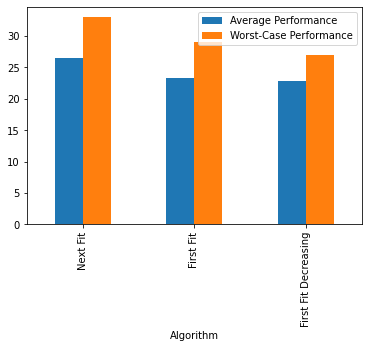

In [78]:
perf_stats.plot.bar() # https://stackoverflow.com/questions/54576615/matplotlib-how-to-plot-bar-graphs-side-by-side-to-compare-values-between-2-col
plt.show()

### Exact Algorithms (**TODO**)